<a href="https://colab.research.google.com/github/BlackJack2021/Zenn_IntroductionToStateSpaceModel/blob/main/20220630_Zenn_%E7%8A%B6%E6%85%8B%E7%A9%BA%E9%96%93%E3%83%A2%E3%83%87%E3%83%AB%E8%B6%85%E5%85%A5%E9%96%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なパッケージのインストール・インポート

In [1]:
# インストール
!pip install statsmodels
!pip install japanize-matplotlib

# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import requests
import io
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
from datetime import datetime
from dateutil.relativedelta import relativedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=224a2e0467093b9ff4a14c30538572fd800f53a5b698edd00e3e049f9c7a779f
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# データの取得及び前処理

In [2]:
url = 'https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_domestic_daily_data.csv'
r = requests.get(url)
df_raw = pd.read_csv(io.BytesIO(r.content))
df_raw

,日付,国内の感染者数_1日ごとの発表数,国内の感染者数_累計,国内の死者数_1日ごとの発表数,国内の死者数_累計
0,2020/1/16,1,1,0,0
1,2020/1/17,0,1,0,0
2,2020/1/18,0,1,0,0
3,2020/1/19,0,1,0,0
4,2020/1/20,0,1,0,0
...,...,...,...,...,...
891,2022/6/25,16587,9242578,9,31117
892,2022/6/26,14237,9256815,12,31129
893,2022/6/27,9570,9266385,13,31142
894,2022/6/28,19384,9285769,108,31250


In [3]:
positive_df = df_raw[['日付', '国内の感染者数_1日ごとの発表数']]
positive_df.columns = ['date', 'number_of_positive']
# 日付を datetime 情報に変換し、 index に付加する
positive_df['date'] = pd.to_datetime(positive_df['date'], format="%Y/%m/%d")
positive_df.set_index('date', inplace=True, drop=False)
positive_df

,date,number_of_positive
date,,
2020-01-16,2020-01-16,1
2020-01-17,2020-01-17,0
2020-01-18,2020-01-18,0
2020-01-19,2020-01-19,0
2020-01-20,2020-01-20,0
...,...,...
2022-06-25,2022-06-25,16587
2022-06-26,2022-06-26,14237
2022-06-27,2022-06-27,9570


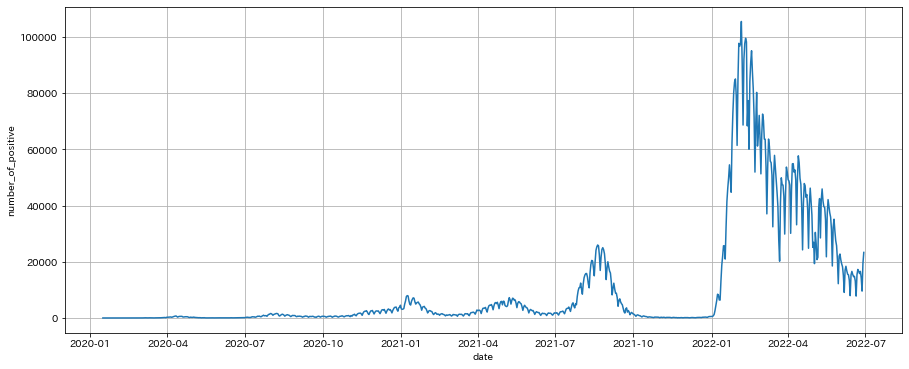

In [4]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(
    data = positive_df,
    x = 'date',
    y = 'number_of_positive',
    ax = ax
)
ax.grid()
plt.show()

## 可視化結果からの示唆
- 感染者数について等比級数的にデータが感染者数が増大したり減少したりしているように見える。
    - この観察は SIR モデルとも近しい（本当は非感染個体数を考えないといけないけれど...。）
    - $x_{t+1} = r x_{t}$ みたいな形でモデリングできないだろうか。
    - ただし $r$ は一定には見えないので、うまくこれが変動する時変係数のモデリングがしたい。
- $r_t$ の変動を考慮する際に、「トレンド」や「季節性」といった要素に分解しながら考えてみたい。

## 具体的な方向性の決定
- $r_t$ を状態空間モデルを用いてモデル化することをゴールとする。
- まず、前処理として $x_{t+1} = r_{t} x_{t}$ の両辺に log を取ると

$$
\begin{aligned}
&\log(x_{t+1}) = \log(r_{t}) + \log(x_{t}) \\
\Leftrightarrow \ &\log(x_{t+1}) - \log(x_{t}) = \log(r_{t})
\end{aligned}
$$

この時の $\log(\alpha_t)$ をモデリングすることにする。そのため、まずは対数差分を得ることから開始する。

- **なぜ対数を取るのか**
    - 後の季節性をモデリングする際に、「積がゼロ」となる制約が必要になる。この時に $\log(\cdot)$ の和がゼロとなる制約を置くことによりその制約を再現するため。
    - 対数差分は近似的に「その対象（ここではコロナ感染者数）の変化率」を表すことを意味する。そのため、$r_t$ をモデリングすることは近似的に「コロナ感染者数」をモデリングすることにつながるため。

In [5]:
positive_df2 = positive_df.copy()
# まず感染者数について対数値をとる。
positive_df2['logged'] = positive_df2['number_of_positive'].apply(lambda x: np.log(x))

# inf を np.nan に置き換え（状態空間モデルでは欠損値を補完することなくモデリングが可能）
positive_df2['logged'] = positive_df2['logged'].replace((-np.inf, np.inf), np.nan)

# 対数差分を取る
positive_df2['y'] = positive_df2['logged'].diff()

# 直後に曜日のデータを用いるため曜日を割り出しておく
positive_df2['day_name'] = positive_df['date'].dt.day_name()

# 最初は人数が少なすぎて対数や対数差分をとる演算が不適切なので、2年前までのデータを対象とする
two_years_ago = datetime.today() - relativedelta(years=2)
positive_df2 = positive_df2.loc[positive_df2.index>=two_years_ago]
positive_df2

,date,number_of_positive,logged,y,day_name
date,,,,,
2020-07-01,2020-07-01,127,4.844187,-0.083067,Wednesday
2020-07-02,2020-07-02,194,5.267858,0.423671,Thursday
2020-07-03,2020-07-03,250,5.521461,0.253603,Friday
2020-07-04,2020-07-04,274,5.613128,0.091667,Saturday
2020-07-05,2020-07-05,208,5.337538,-0.275590,Sunday
...,...,...,...,...,...
2022-06-25,2022-06-25,16587,9.716375,0.047724,Saturday
2022-06-26,2022-06-26,14237,9.563599,-0.152775,Sunday
2022-06-27,2022-06-27,9570,9.166388,-0.397211,Monday


## 対数差分の可視化
### 時系列プロット

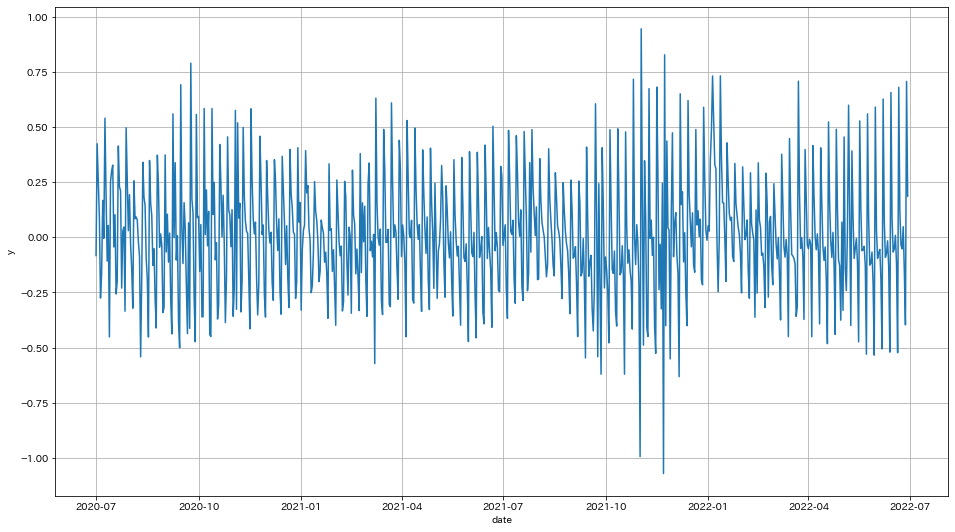

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(
    data = positive_df2,
    x = 'date',
    y = 'y',
    ax = ax
)
ax.grid()
fig.show()

#### 可視化の結果から分かること
- 全体的には右肩上がり、右肩下がりといった傾向は確認されない
- 一方局所的に右肩上がりのトレンドだったり右肩下がりのトレンドだったりする。

### 曜日ごとのプロット

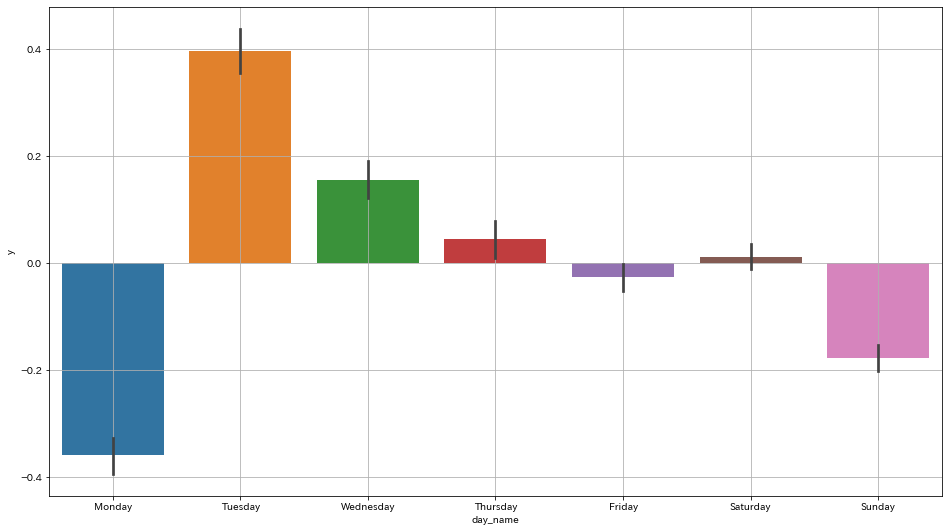

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(
    data = positive_df2,
    x = 'day_name',
    y = 'y',
    ax = ax,
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
ax.grid()
fig.show()

#### 可視化の結果から分かること
- 曜日ごとに割と増加のトレンドが異なる
- 週次の周期性はトレンドに含めてもいいかも。

# 状態空間モデルを用いたモデリング
## **ローカルレベルモデルの構築**
- まずはシンプルなモデル(**ローカルレベルモデル**)を構築する。

$$
\begin{aligned}
y_t &= \mu_t + u_{y,t}\\
\mu_{t} &= \mu_{t-1}+ u_{\mu,t}
\end{aligned}
$$

- $\mu_t$ : トレンドを表す。個のトレンドは2式目で示すように時変的である。

- カスタム時の各種変数の定義は基本的にこちらに書いてある通り。
    - 引用元は[公式ドキュメント](https://www.statsmodels.org/stable/statespace.html) です。

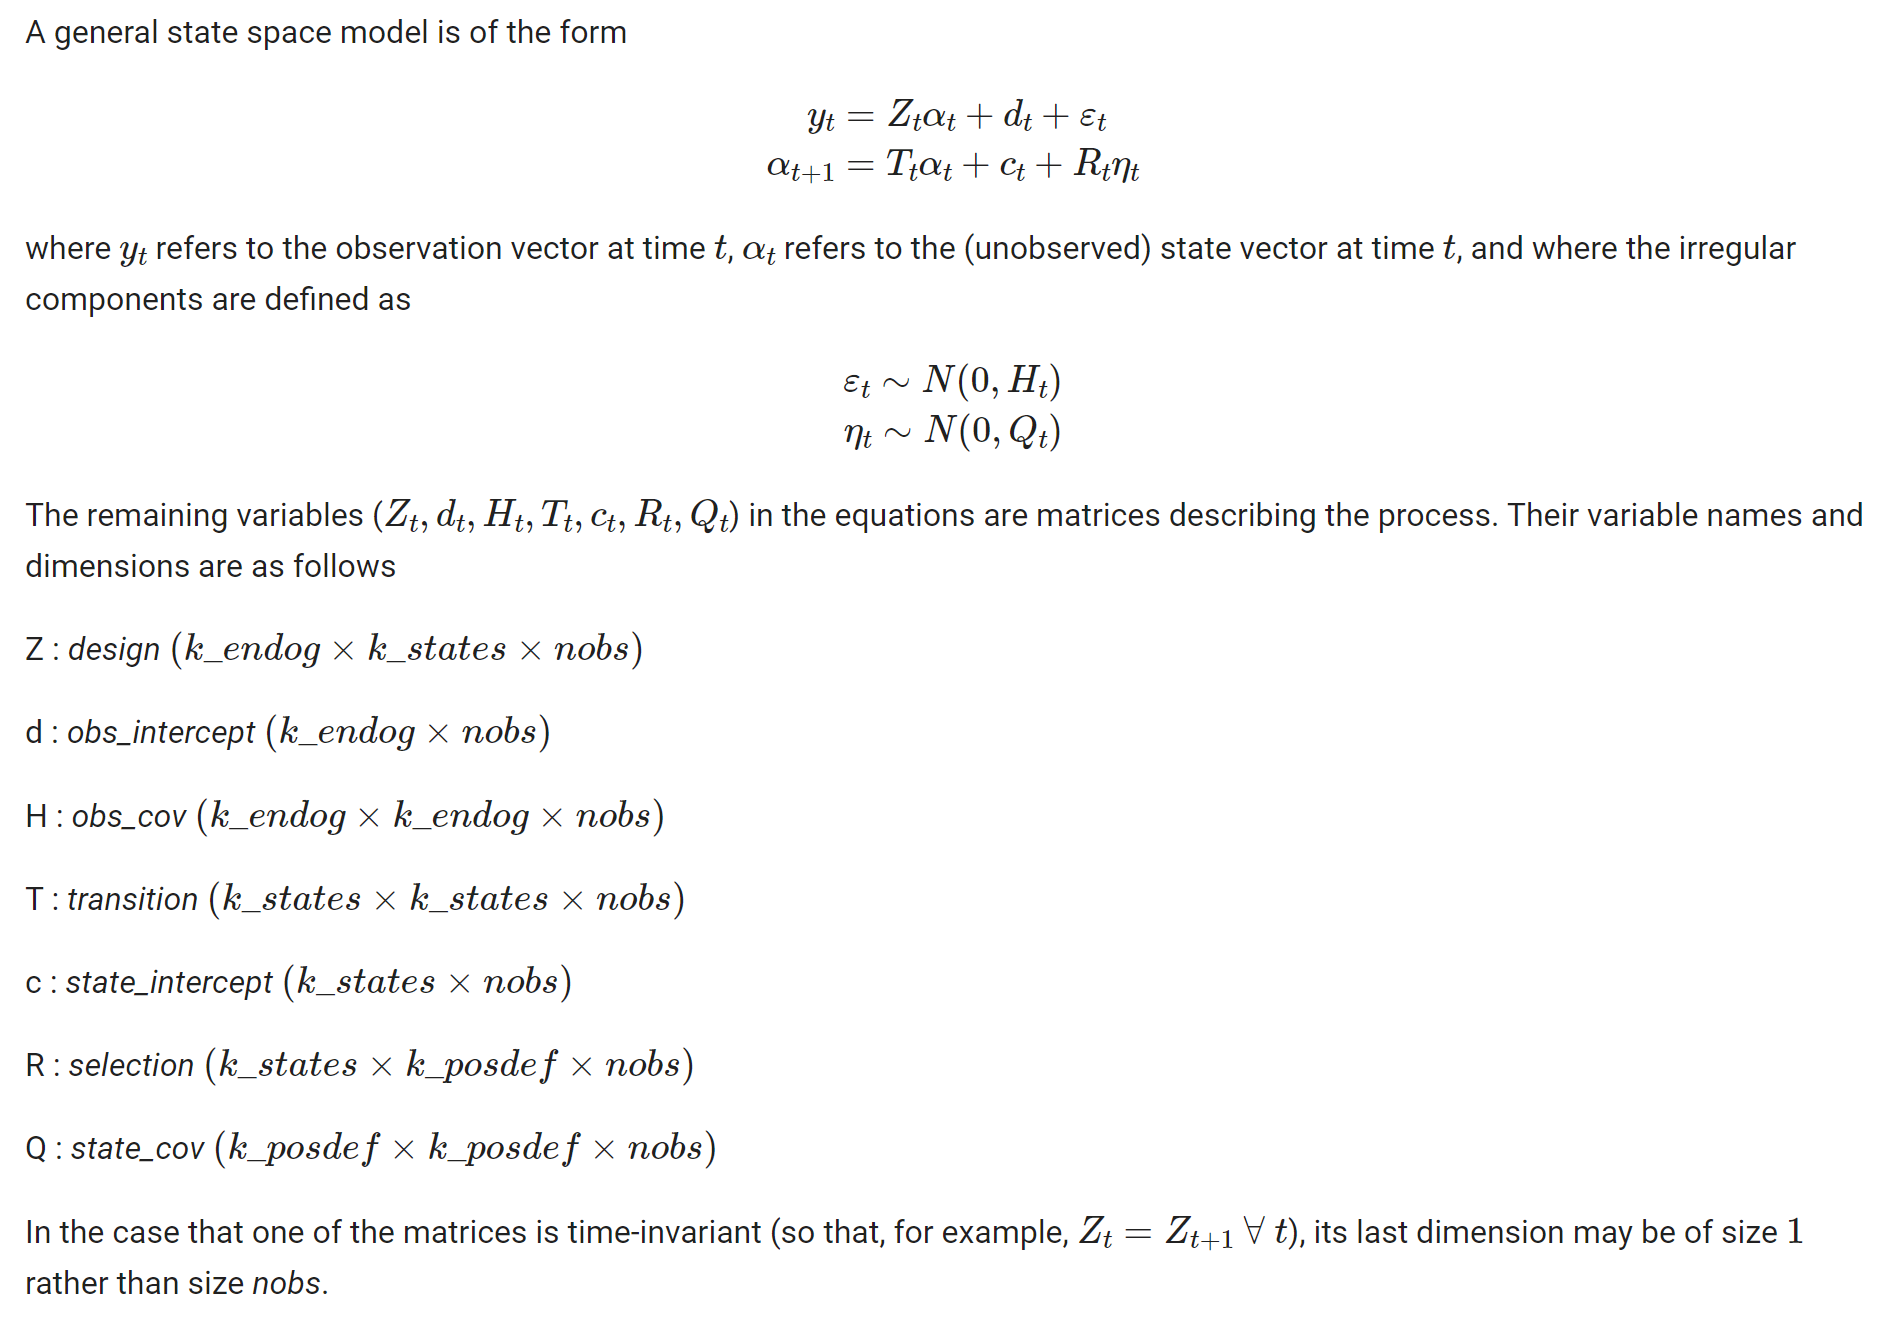

In [8]:
class LocalLevelModel(sm.tsa.statespace.MLEModel):
    
    # クラス変数として各種名称, 非負であるもの、推定の初期値を宣言。
    param_names = ['観測誤差','トレンド誤差']
    positive_parameter_index = [0, 1]
    start_params = [0.01, 0.01]

    def __init__(self, endog):
        
        # まず親クラスのインストラクタを起動する
        super(LocalLevelModel, self).__init__(
            endog = endog,
            k_states = 1, # state の数を指定する。今回は mu 一つだけ。
            freq = 'D', # date 単位のデータであることを指定する。
            initialization = 'diffuse' # 推定の際に散漫カルマンフィルタの利用を指示。
        )

        # ssm['design'] で状態と観測変数の関係性を定義する(次元は「観測変数の数」＊「状態変数の数」)
        # 今回は状態変数の値がそのまま観測変数への影響となるので、1*1行列の要素に1を代入すればよい。
        k_endog = 1
        self.ssm['design'] = np.zeros([k_endog, self.k_states])
        self.ssm['design',0,0] = 1

        # ssm['transition'] で状態の遷移のルールを記述（次元は「状態変数の数」*「状態変数の数」）
        # 今回は過去のトレンド変数（＋誤差）がそのまま今回のトレンドに受け継がれるので、1*1行列の要素に1を代入すればよい。
        self.ssm['transition'] = np.zeros([self.k_states, self.k_states])
        self.ssm['transition', 0, 0] = 1
        
        # ssm['selection'] で状態と状態誤差の関係性を定義（次元は「状態変数の数」*「状態誤差の数」）
        # 今回はそのままトレンド誤差をトレンドに反映させるので、1*1行列の要素に1を代入すればよい。
        k_posdef = 1 # 状態誤差の数
        self.ssm['selection'] = np.zeros([self.k_states, k_posdef])
        self.ssm['selection', 0, 0] = 1



    def transform_params(self, unconstrained):
        '''
        正の値が指定されたパラメータについて二乗値をとります。
        この操作により、値が二乗されますが仮にマイナスの値が入っていたとしてもプラスの値になります。
        二乗されてしまった分については直後の untransform_params にて平方根に変換します。
        '''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelModel, self).update(params, **kwargs)
        # 0番目のパラメータ=観測誤差の更新値を観測誤差分散共分散行列に代入
        self.ssm['obs_cov', 0, 0] = params[0]
        # 1番目のパラメータ=トレンド誤差の更新値を状態誤差分散共分散行列に代入
        self.ssm['state_cov', 0, 0] = params[1]

In [9]:
endog = 'y'
local_level_model = LocalLevelModel(endog=positive_df2[endog])
result_llm = local_level_model.fit()
print(result_llm.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  729
Model:                LocalLevelModel   Log Likelihood                -100.852
Date:                Thu, 30 Jun 2022   AIC                            207.705
Time:                        02:56:43   BIC                            221.480
Sample:                    07-01-2020   HQIC                           213.019
                         - 06-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
観測誤差           0.0764      0.004     21.116      0.000       0.069       0.083
トレンド誤差      2.403e-11   2.25e-06   1.07e-05      1.000   -4.41e-06    4.41e-06
Ljung-Box (Q):                     2195.77   Jarque-

In [10]:
estimated_states = result_llm.smoothed_state
trend = estimated_states[0]

result_df = pd.DataFrame({
    '日付': positive_df2['date'],
    '観測値': positive_df2[endog],
    'トレンド': trend,
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='感染者数対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '感染者数対数差分',
    color = 'decomposition'
)
fig.show()

In [11]:
endog = 'y'
unobserved_components_local_linear = sm.tsa.UnobservedComponents(
    endog = positive_df2[endog],
    level = 'local level',
    #seasonal = 7,
    #stochastic_seasonal=True
)
result_uoll = unobserved_components_local_linear.fit()
print(result_uoll.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  729
Model:                    local level   Log Likelihood                 -99.933
Date:                Thu, 30 Jun 2022   AIC                            203.867
Time:                        02:56:44   BIC                            213.047
Sample:                    07-01-2020   HQIC                           207.409
                         - 06-29-2022                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0764      0.004     21.116      0.000       0.069       0.083
sigma2.level        2.5e-11   2.25e-06   1.11e-05      1.000   -4.41e-06    4.41e-06
Ljung-Box (Q):              

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



#### 観察されること
- ほとんどすべてを「説明できない部分」として説明。
- その結果トレンドとして推定されそうな部分も全く推定されなくなっている。

#### **ネクストアクション**
- 季節性を組み込んだローカルレベルモデルを構築したい。
    - そうすれば「説明できない部分」の影響を小さくできそうなので、きちんとトレンドを推定できるようになるかも。

## **季節性を追加したローカルレベルモデル**

- 観測値と状態の関係
$$
\begin{aligned}
y_t = \mu_t + \gamma_{1,t} + u_t
\end{aligned}
$$

- 状態遷移
$$
\begin{aligned}
\mu_t &= \mu_{t-1} + u_{\mu,t} \\
\gamma_{1,t} &= \sum_{i=1}^{6}\gamma_{i,t-1}+u_{\gamma,t} \\
\gamma_{2,t} &= \gamma_{1,t-1} \\
\gamma_{3,t} &= \gamma_{2,t-1} \\
\gamma_{4,t} &= \gamma_{3,t-1} \\
\gamma_{5,t} &= \gamma_{4,t-1} \\
\gamma_{6,t} &= \gamma_{5,t-1} \\
\end{aligned}
$$


In [12]:
class LocalLevelSeasonalModel(sm.tsa.statespace.MLEModel):

    param_names = ['観測誤差', 'トレンド誤差', '季節誤差']
    positive_parameter_index = [0,1,2]
    start_params = [0.01, 0.01, 0.01]

    # 更新。今回は状態誤差として2つ攪乱項を用いているので2つであると指定。
    k_posdef = 2

    def __init__(self, endog):
        # 初期設定
        super(LocalLevelSeasonalModel, self).__init__(
            endog = endog,
            k_states = 7, # 今回は状態が7つ,
            k_posdef = self.k_posdef, # k_posdef は2重で指定しないとエラーになるので指定。
            freq='D',
            initialization = 'diffuse'
        )
        # design matrix (観測値と状態の関係性)の指定
        self.ssm['design'] = np.array(
            [[1, 1, 0, 0, 0, 0, 0]]
        )

        # transition matrix (現在状態と過去状態の関係性)の指定
        self.ssm['transition'] = np.array([
            [1, 0, 0, 0, 0, 0, 0],
            [0, -1, -1, -1, -1, -1, -1],
            [0, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 0]
        ])

        # selection matrix (状態と状態誤差の関係性)の指定
        self.ssm['selection'] = np.zeros([self.k_states, self.k_posdef])
        self.ssm['selection',0,0] = 1
        self.ssm['selection',1,1] = 1

    
    def transform_params(self, unconstrained):
        '''指定したパラメータに関して正の値に入るように処理をします。'''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelSeasonalModel, self).update(params, **kwargs)
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['state_cov', 1, 1] = params[2]

In [13]:
endog = 'y'
local_level_seasonal_model = LocalLevelSeasonalModel(endog=positive_df2[endog])
result_llsm = local_level_seasonal_model.fit()
print(result_llsm.summary())

                              Statespace Model Results                             
Dep. Variable:                           y   No. Observations:                  729
Model:             LocalLevelSeasonalModel   Log Likelihood                 286.511
Date:                     Thu, 30 Jun 2022   AIC                           -553.023
Time:                             02:56:44   BIC                           -507.106
Sample:                         07-01-2020   HQIC                          -535.306
                              - 06-29-2022                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
観測誤差           0.0193      0.001     26.674      0.000       0.018       0.021
トレンド誤差      8.725e-05   2.82e-05      3.094      0.002     3.2e-05       0.000
季節誤差        

In [14]:
estimated_states = result_llsm.smoothed_state
trend = estimated_states[0]
seasonal = estimated_states[1]

result_df = pd.DataFrame({
    '日付': positive_df2['date'],
    '観測値': positive_df2[endog],
    'トレンド': trend,
    '観測値＋トレンド': trend+seasonal
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '対数差分',
    color = 'decomposition'
)
fig.show()
fig.write_html("modeling_result.html")

#### 観察されること
- 先ほどよりも大分ましな推定となった。
    - 週次の季節性をモデルに組み込むことでトレンドをうまく拾えるようになった。

In [15]:
# 1か月先まで予測を行ってみる。steps で予測期間（ここでは日数）を指定する。
one_month_forecasts = result_llsm.get_forecast(steps=30)
# summary_frame メソッドにより点予測・予測信頼区間の情報を出力可能。alpha で信頼係数を指定（0.05 なら 95%信頼区間）。
summary_of_forecasts_df = one_month_forecasts.summary_frame(alpha=0.05)
summary_of_forecasts_df

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-06-30,-0.058132,0.160119,-0.371960,0.255696
2022-07-01,-0.040773,0.160131,-0.354624,0.273079
2022-07-02,0.033897,0.160285,-0.280255,0.348049
2022-07-03,-0.111988,0.160472,-0.426508,0.202532
2022-07-04,-0.470006,0.160652,-0.784878,-0.155133
2022-07-05,0.613775,0.160778,0.298656,0.928894
2022-07-06,0.106453,0.160780,-0.208671,0.421577
2022-07-07,-0.058132,0.165566,-0.382635,0.266371
2022-07-08,-0.040773,0.165577,-0.365298,0.283752
2022-07-09,0.033897,0.165725,-0.290919,0.358713


In [16]:
summary_of_forecasts_df = summary_of_forecasts_df[['mean','mean_ci_lower','mean_ci_upper']]
summary_of_forecasts_df.columns = ['point_prediction', 'confidence_interval_low', 'confidence_interval_high']
result_df = pd.merge(summary_of_forecasts_df, positive_df2[endog], left_index=True, right_index=True, how='outer').reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = result_df['index'],
    y = result_df[endog],
    name = '観測値'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['confidence_interval_low'],
    line={'color':'yellow'},
    name='下側信頼区間95%'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['confidence_interval_high'],
    line={'color':'yellow'},
    fill='tonexty',
    name='上側信頼区間95%'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['point_prediction'],
    line={'color':'red'},
    name='点予測値'
))

fig.show()